In [2]:
# -*- coding: utf-8 -*-
from __future__ import print_function
import cntk as C
from cntk import load_model, combine, CloneMethod
from cntk.layers import placeholder
from cntk.logging.graph import find_by_name
import cv2 as cv
import numpy as np
import math
import time
import util
import matplotlib
import pylab as plt
import os
from numpy import ma
from scipy.ndimage.filters import gaussian_filter

base_dir = os.path.abspath(".")


# base_model = load_model("../model/pose_net.cntkmodel")
base_model = load_model(os.path.join(base_dir, "model", "pose_net.cntkmodel"))
data = C.input_variable(shape=(3, C.FreeDimension, C.FreeDimension), name="data")
def clone_model(base_model, from_node_names, to_node_names, clone_method):
    from_nodes = [find_by_name(base_model, node_name) for node_name in from_node_names]
    if None in from_nodes:
        print("Error: could not find all specified 'from_nodes' in clone. Looking for {}, found {}"
              .format(from_node_names, from_nodes))
    to_nodes = [find_by_name(base_model, node_name) for node_name in to_node_names]
    if None in to_nodes:
        print("Error: could not find all specified 'to_nodes' in clone. Looking for {}, found {}"
              .format(to_node_names, to_nodes))
    input_placeholders = dict(zip(from_nodes, [placeholder() for x in from_nodes]))
    cloned_net = combine(to_nodes).clone(clone_method, input_placeholders)
    return cloned_net

predictor = clone_model(base_model, ['data'], ["Mconv7_stage6_L1", "Mconv7_stage6_L2"], CloneMethod.freeze)
pred_net = predictor(data)
Mconv7_stage6_L1 = pred_net.outputs[0]
Mconv7_stage6_L2 = pred_net.outputs[1]


# scale_search = [0.5, 1.0, 1.5, 2.0]
scale_search = [0.5]
boxsize = 368
stride = 8
padValue = 128
thre1 = 0.1
thre2 = 0.05

# test_image = '../sample/ski.jpg'
test_image = os.path.join(base_dir, "sample/3.jpg")
oriImg = cv.imread(test_image)  # B,G,R order
print("oriImg shape: ", oriImg.shape)
multiplier = [x * boxsize / oriImg.shape[0] for x in scale_search]
print("multiplier: ", multiplier)


heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))
print("heatmap_avg: ", heatmap_avg.shape, "paf_avg: ", paf_avg.shape)

oriImg shape:  (641, 950, 3)
multiplier:  [0.2870514820592824]
heatmap_avg:  (641, 950, 19) paf_avg:  (641, 950, 38)


In [3]:
print(C.all_devices())

(GPU[0] Tesla M40 24GB, CPU)


In [4]:
print(Mconv7_stage6_L1)
print(Mconv7_stage6_L2)

Output('Mconv7_stage6_L1', [#], [38 x * x *])
Output('Mconv7_stage6_L2', [#], [19 x * x *])


In [5]:
for m in range(len(multiplier)):
    scale = multiplier[m]
    imageToTest = cv.resize(oriImg, (0, 0), fx=scale, fy=scale, interpolation=cv.INTER_CUBIC)
    print("imageToTest: ", imageToTest.shape)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, stride, padValue)
    print("imageToTest_padded: ", imageToTest_padded.shape, "pad: ", pad)
    im = np.transpose(np.float32(imageToTest_padded[:, :, :, np.newaxis]), (3, 2, 0, 1)) / 256 - 0.5
    im = np.ascontiguousarray(im)
    start_time = time.time()
    output = pred_net.eval({pred_net.arguments[0]: [im]})
    print("Mconv7_stage6_L1: ", output[Mconv7_stage6_L1].shape, "Mconv7_stage6_L2: ", output[Mconv7_stage6_L2].shape)
    # print output[Mconv7_stage6_L2]
    print('At scale %.2f, The CNN took %.2f ms.' % (scale_search[m], 1000 * (time.time() - start_time)))

    # extract outputs, resize, and remove padding
    # heatmap = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[1]].data), (1, 2, 0))  # output 1 is heatmaps
    heatmap = np.transpose(np.squeeze(output[Mconv7_stage6_L2]), (1, 2, 0))  # output 1 is heatmaps
    heatmap = cv.resize(heatmap, (0, 0), fx=stride, fy=stride, interpolation=cv.INTER_CUBIC)
    heatmap = heatmap[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    heatmap = cv.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

    # paf = np.transpose(np.squeeze(net.blobs[output_blobs.keys()[0]].data), (1, 2, 0))  # output 0 is PAFs
    paf = np.transpose(np.squeeze(output[Mconv7_stage6_L1]), (1, 2, 0))  # output 0 is PAFs
    paf = cv.resize(paf, (0, 0), fx=stride, fy=stride, interpolation=cv.INTER_CUBIC)
    paf = paf[:imageToTest_padded.shape[0] - pad[2], :imageToTest_padded.shape[1] - pad[3], :]
    paf = cv.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv.INTER_CUBIC)

    heatmap_avg = heatmap_avg + heatmap / len(multiplier)
    paf_avg = paf_avg + paf / len(multiplier)


U = paf_avg[:, :, 16] * -1
V = paf_avg[:, :, 17]
X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U ** 2 + V ** 2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)



all_peaks = []
peak_counter = 0

for part in range(19 - 1):
    x_list = []
    y_list = []
    map_ori = heatmap_avg[:, :, part]
    map = gaussian_filter(map_ori, sigma=3)

    map_left = np.zeros(map.shape)
    map_left[1:, :] = map[:-1, :]
    map_right = np.zeros(map.shape)
    map_right[:-1, :] = map[1:, :]
    map_up = np.zeros(map.shape)
    map_up[:, 1:] = map[:, :-1]
    map_down = np.zeros(map.shape)
    map_down[:, :-1] = map[:, 1:]

    peaks_binary = np.logical_and.reduce(
        (map >= map_left, map >= map_right, map >= map_up, map >= map_down, map > thre1))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
    peaks_with_score = [x + (map_ori[x[1], x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

imageToTest:  (184, 273, 3)
imageToTest_padded:  (184, 280, 3) pad:  [0, 0, 0, 7]
Mconv7_stage6_L1:  (1, 38, 23, 35) Mconv7_stage6_L2:  (1, 19, 23, 35)
At scale 0.50, The CNN took 1396.46 ms.


In [6]:
print(all_peaks)
print(np.array(all_peaks).shape)
print(len(all_peaks))
print(len(all_peaks[0]))
print(len(all_peaks[0][0]))

[[(594, 132, 0.99508237838745117, 0), (286, 172, 0.94504845142364502, 1)], [(576, 235, 0.9708678126335144, 2), (275, 259, 0.90809595584869385, 3)], [(192, 248, 0.82020437717437744, 4), (486, 256, 0.93149977922439575, 5)], [(108, 330, 0.83102071285247803, 6), (455, 406, 0.8887486457824707, 7)], [(140, 273, 0.98870229721069336, 8), (435, 523, 0.76850485801696777, 9)], [(668, 215, 0.86453670263290405, 10), (360, 265, 0.89541864395141602, 11)], [(794, 234, 0.83568710088729858, 12), (404, 407, 0.91572749614715576, 13)], [(831, 176, 0.89676737785339355, 14), (417, 516, 0.65201801061630249, 15)], [(209, 492, 0.73032212257385254, 16), (537, 501, 0.76041889190673828, 17)], [(193, 638, 0.281309574842453, 18)], [], [(642, 491, 0.72527194023132324, 19), (325, 499, 0.69851601123809814, 20)], [], [], [(568, 122, 0.95766085386276245, 21), (265, 152, 0.97578209638595581, 22)], [(599, 114, 0.95902997255325317, 23), (302, 152, 0.95595031976699829, 24)], [(525, 143, 0.90255159139633179, 25), (234, 152, 0

In [8]:

# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
           [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
           [1, 16], [16, 18], [3, 17], [6, 18]]
# the middle joints heatmap correpondence
mapIdx = [[31, 32], [39, 40], [33, 34], [35, 36], [41, 42], [43, 44], [19, 20], [21, 22], \
          [23, 24], [25, 26], [27, 28], [29, 30], [47, 48], [49, 50], [53, 54], [51, 52], \
          [55, 56], [37, 38], [45, 46]]

connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf_avg[:, :, [x - 19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0] - 1]
    candB = all_peaks[limbSeq[k][1] - 1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if (nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0] * vec[0] + vec[1] * vec[1])
                vec = np.divide(vec, norm)

                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))

                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts) / len(score_midpts) + min(0.5 * oriImg.shape[0] / norm - 1, 0)
                criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append(
                        [i, j, score_with_dist_prior, score_with_dist_prior + candA[i][2] + candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0, 5))
        for c in range(len(connection_candidate)):
            i, j, s = connection_candidate[c][0:3]
            if (i not in connection[:, 3] and j not in connection[:, 4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if (len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:, 0]
        partBs = connection_all[k][:, 1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])):  # = 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)):  # 1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1

            if found == 1:
                j = subset_idx[0]
                if (subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2:  # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print("found = 2")
                membership = ((subset[j1] >= 0).astype(int) + (subset[j2] >= 0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0:  # merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else:  # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i, :2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])
# delete some rows of subset which has few parts occur
deleteIdx = []
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2] / subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

## Subsets
### 预测的对应关节序号
### last number in each row is the total parts number of that person
### the second last number in each row is the score of the overall configuration

In [9]:
print("所有关节总数:", np.sum(subset!=-1)-4)
print("shape of subset:", subset.shape)
print("subset:", subset)
print("candidate:", candidate)

所有关节总数: 28
shape of subset: (2, 20)
subset: [[  0.           2.           5.           7.           9.          10.
   12.          14.          17.          -1.          -1.          19.
   -1.          -1.          21.          23.          25.          -1.
   23.08221134  13.        ]
 [  1.           3.           4.           6.           8.          11.
   13.          15.          16.          18.          -1.          20.
   -1.          -1.          22.          24.          26.          27.
   25.78635499  15.        ]]
candidate: [[  5.94000000e+02   1.32000000e+02   9.95082378e-01   0.00000000e+00]
 [  2.86000000e+02   1.72000000e+02   9.45048451e-01   1.00000000e+00]
 [  5.76000000e+02   2.35000000e+02   9.70867813e-01   2.00000000e+00]
 [  2.75000000e+02   2.59000000e+02   9.08095956e-01   3.00000000e+00]
 [  1.92000000e+02   2.48000000e+02   8.20204377e-01   4.00000000e+00]
 [  4.86000000e+02   2.56000000e+02   9.31499779e-01   5.00000000e+00]
 [  1.08000000e+02   3.30000

### 绘制出所有的关节！

[(594, 132, 0.99508237838745117, 0), (286, 172, 0.94504845142364502, 1)]
[(576, 235, 0.9708678126335144, 2), (275, 259, 0.90809595584869385, 3)]
[(192, 248, 0.82020437717437744, 4), (486, 256, 0.93149977922439575, 5)]
[(108, 330, 0.83102071285247803, 6), (455, 406, 0.8887486457824707, 7)]
[(140, 273, 0.98870229721069336, 8), (435, 523, 0.76850485801696777, 9)]
[(668, 215, 0.86453670263290405, 10), (360, 265, 0.89541864395141602, 11)]
[(794, 234, 0.83568710088729858, 12), (404, 407, 0.91572749614715576, 13)]
[(831, 176, 0.89676737785339355, 14), (417, 516, 0.65201801061630249, 15)]
[(209, 492, 0.73032212257385254, 16), (537, 501, 0.76041889190673828, 17)]
[(193, 638, 0.281309574842453, 18)]
[]
[(642, 491, 0.72527194023132324, 19), (325, 499, 0.69851601123809814, 20)]
[]
[]
[(568, 122, 0.95766085386276245, 21), (265, 152, 0.97578209638595581, 22)]
[(599, 114, 0.95902997255325317, 23), (302, 152, 0.95595031976699829, 24)]
[(525, 143, 0.90255159139633179, 25), (234, 152, 0.9532113075256347

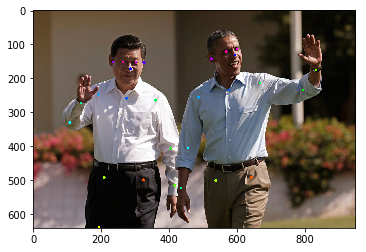

In [33]:

# print subset
stickwidth = 4

# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv.imread(test_image)  # B,G,R order

for i in range(18):
    rgba = np.array(cmap(1 - i / 18. - 1. / 36))
    rgba[0:3] *= 255
    print(all_peaks[i])
    for j in range(len(all_peaks[i])):
        cv.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)
plt.imshow(canvas[:, :, [2, 1, 0]])

0
subset[0]: [  0.           2.           5.           7.           9.          10.          12.
  14.          17.          -1.          -1.          19.          -1.          -1.
  21.          23.          25.          -1.          23.08221134  13.        ]
np.array(limbSeq[0]) - 1 [1 2]
index: [ 2.  5.]
X, Y: (531, 245)
1
subset[1]: [  1.           3.           4.           6.           8.          11.          13.
  15.          16.          18.          -1.          20.          -1.          -1.
  22.          24.          26.          27.          25.78635499  15.        ]
np.array(limbSeq[0]) - 1 [1 2]
index: [ 3.  4.]
X, Y: (233, 253)
######
0
subset[0]: [  0.           2.           5.           7.           9.          10.          12.
  14.          17.          -1.          -1.          19.          -1.          -1.
  21.          23.          25.          -1.          23.08221134  13.        ]
np.array(limbSeq[1]) - 1 [1 5]
index: [  2.  10.]
X, Y: (622, 225)
1
subset[1]: 

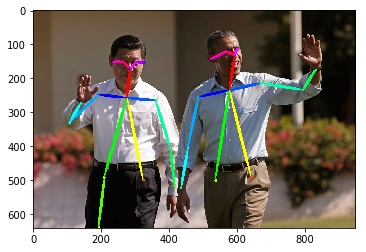

In [42]:
to_plot = cv.addWeighted(oriImg, 0.3, canvas, 0.7, 0)

for i in range(17):
    for n in range(len(subset)):
        print(n)
        index = subset[n][np.array(limbSeq[i]) - 1]
        print("subset[%s]:"%n, subset[n])
        print("np.array(limbSeq[%s]) - 1"%i, np.array(limbSeq[i]) - 1)
        print("index:", index)
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0]
        X = candidate[index.astype(int), 1]
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv.ellipse2Poly((int(mY), int(mX)), (int(length / 2), stickwidth), int(angle), 0, 360, 1)
        print("X, Y:", (int(mY), int(mX)))
        cv.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
    print("######")

# plt.imsave("../sample/preview.jpg", canvas[:, :, [2, 1, 0]])
# plt.imsave(os.path.join(base_dir, "sample", "4.jpg"), canvas[:, :, [2, 1, 0]])
plt.imshow(canvas[:, :, [2, 1, 0]])